<a href="https://colab.research.google.com/github/Selva-Subramanian/Yes_Bank_Closing_Price_Prediction/blob/main/YES_BANK_STOCK_PRICE_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

Yes Bank is a well-known bank in the Indian financial domain. Since 2018, it has been in the
news because of the fraud case involving Rana Kapoor. Owing to this fact, it was interesting
to see how that impacted the stock prices of the company and whether Time series models
or any other predictive models can do justice to such situations. This dataset has monthly
stock prices of the bank since its inception and includes closing, starting, highest, and lowest
stock prices of every month. The main objective is to predict the stock’s closing price of the
month.

In [2]:
# mount drive to load dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [137]:
# importing the required libraries
import warnings                                        # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                                     # vectors and matrices
import pandas as pd                                    # tables and data manipulations
import matplotlib.pyplot as plt                        # plots
import seaborn as sns
import plotly.express as px                       

from datetime import datetime                          # to convert to date

from dateutil.relativedelta import relativedelta       # working with dates with style
from scipy.optimize import minimize                    # for function minimization

from sklearn.preprocessing import MinMaxScaler         # scale the data

from sklearn.model_selection import train_test_split   # splitting train and test data
from sklearn.linear_model import LinearRegression      # regression model

from sklearn.metrics import (r2_score,                  # import required metrics
mean_squared_error,  mean_absolute_percentage_error)

import statsmodels.formula.api as smf                  # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                          # some useful functions
from tqdm import tqdm_notebook



%matplotlib inline

In [4]:
# load the dataset
working_dir_path = "/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/CP2 - Supervised - Regression/"
df = pd.read_csv(working_dir_path + "data_YesBank_StockPrices.csv")

In [5]:
df.head()

,Date,Open,High,Low,Close
0,Jul-05,13.00,14.00,11.25,12.46
1,Aug-05,12.58,14.88,12.55,13.42
2,Sep-05,13.48,14.87,12.27,13.30
3,Oct-05,13.20,14.47,12.40,12.99
4,Nov-05,13.35,13.88,12.88,13.41


In [6]:
# let's look at the details of our features 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    185 non-null    object 
 1   Open    185 non-null    float64
 2   High    185 non-null    float64
 3   Low     185 non-null    float64
 4   Close   185 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.4+ KB


*  We have a total of 185 entries. <br>
*  No null values. <br>
*  Date column is of 'object' datatype we have to convert it to 'datetime' but let's just ignore that part for now, we will take care of that later.


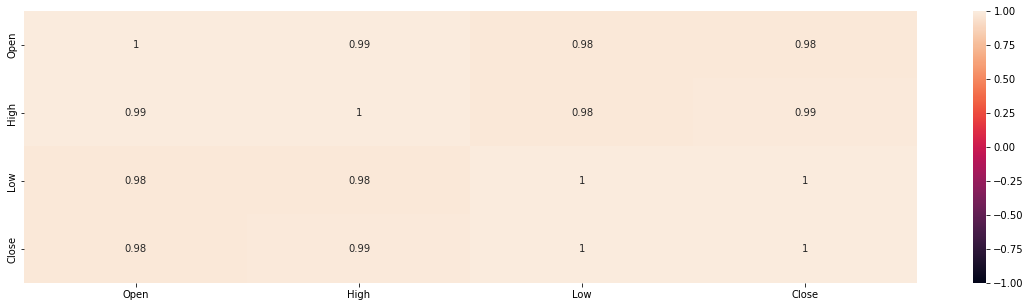

In [8]:
# let's see if corelation exists

plt.figure(figsize=(20,5))
cor = sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap=None, annot=True )

### Every feature is extremely corelated with each other, so taking just one feature or average of these features would suffice for our regression model as linear regression assumes there is no multi colinearity in the features.

In [13]:
# Creating a new feature based on average of other features in the dataset

df['OHL'] = df[['Open', 'High', 'Low']].mean(axis=1).round(2)
df.head()

,Date,Open,High,Low,Close,OHL
0,Jul-05,13.00,14.00,11.25,12.46,12.75
1,Aug-05,12.58,14.88,12.55,13.42,13.34
2,Sep-05,13.48,14.87,12.27,13.30,13.54
3,Oct-05,13.20,14.47,12.40,12.99,13.36
4,Nov-05,13.35,13.88,12.88,13.41,13.37


### Linear regression also assumes a linear relationship between the target variables and independent variables, let's check if such relationship exists through a scatter plot

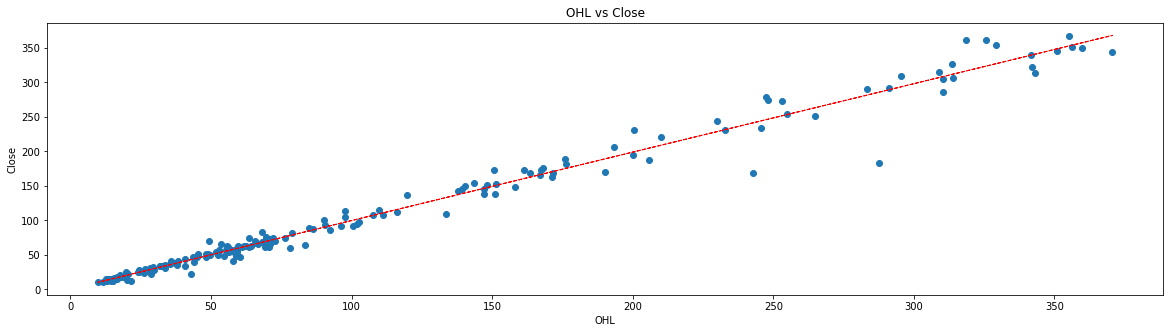

In [141]:
# scatter plot to see the relationship between dependent & independent variables

fig = plt.figure(figsize=(20,5))
ax = fig.gca()
plt.scatter(df['OHL'], df['Close'])
plt.xlabel('OHL')
plt.ylabel('Close')
ax.set_title('OHL vs Close')
z = np.polyfit(df['OHL'], df['Close'], 1)
y_hat = np.poly1d(z)(df['OHL'])
plt.plot(df['OHL'], y_hat, "r--", lw=1)
plt.show()

### Great, let's start building a simple regression model and then we'll improve the performance from that benchmark

### <b> Model Building

In [139]:
# assign features to x and y
x = df.loc[:,['OHL']]
y = df.loc[:,'Close']

# split data for train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state=0)

# preprocess the data
norm = MinMaxScaler().fit(x_train)
x_train = norm.transform(x_train)
x_test = norm.transform(x_test)

# initialise the model
LR = LinearRegression()

# fit the model
LR.fit(x_train, y_train)
print('training set error: {}'.format(LR.score(x_train, y_train)))

# make predictions
y_pred = LR.predict(x_test)

# evaluate predictions
mse = mean_squared_error(y_pred, y_test)
print('mean squared error: {}'.format(mse))
rmse = np.sqrt(mse)
print('root mean squared error: {}'.format(rmse))
mape = mean_absolute_percentage_error(y_pred, y_test)
print('mean absolute percentage error: {}'.format(mape))
r2 = r2_score(y_pred, y_test)
print('r2_score: {}'.format(r2))

training set error: 0.9782425968296271
mean squared error: 165.59388751824335
root mean squared error: 12.868328854915209
mean absolute percentage error: 0.05977498150268839
r2_score: 0.9843820201265416


In [15]:
# convert string object to datetime object
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, "%b-%y"))

In [16]:
# let's visualise the data
fig = px.line(df, df['Date'], df['Close'], title='Monthly closing price', template = 'plotly_dark')
fig.update_layout(
    xaxis=dict(title='Year'),
    yaxis=dict(title='Closing price'),
    autosize=False,
    width=1400,
    height=400)

fig.show()

### A moving average much better than a naive forecast ($\hat{y}_t = y_{t-1}$). A **moving average** is the average of previous $k$ values. <br>  $\hat{y}_t = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [18]:
# function for calculating moving average

def moving_average(series, n ):
  
  """
  Calculate average of last n observation
  """
  
  return np.average(series[-n:])

moving_average(df['Close'],12) # prediction for next month closing price using observed previous 12 months data

24.175833333333333

### Unfortunately we can make only one prediction, to make further predictions we need to have the actual observed values. However moving average can be used to identify the trends by smoothing the time series using a pandas implementation [`DataFrame.rolling(window).mean()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html).

In [41]:
# function for plotting moving average

def ma(series, window, plot_intervals=False):

  """
  series - dataframe column with timeseries
  window - rolling window size
  """

  rolling_mean = series.rolling(window=window).mean()

  plt.figure(figsize=(20,5))
  plt.title('Moving average \n window size = {}'.format(window))
  plt.plot(df['Date'], rolling_mean, "g", label = "Rolling mean trend")
  
  # plotting confidence intervals
  if plot_intervals:
    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    deviation = np.std(series[window] - rolling_mean[window:])
    lower_bound = rolling_mean - (mae + deviation)
    upper_bound = rolling_mean + (mae + deviation)
    plt.plot(df['Date'], lower_bound, "r--", label = "Upper/Lower bounds")
    plt.plot(df['Date'], upper_bound, "r--")
  
  plt.plot(df['Date'], series, label = "Actual values")
  plt.legend(loc="upper left")
  plt.grid(True)
  plt.show()

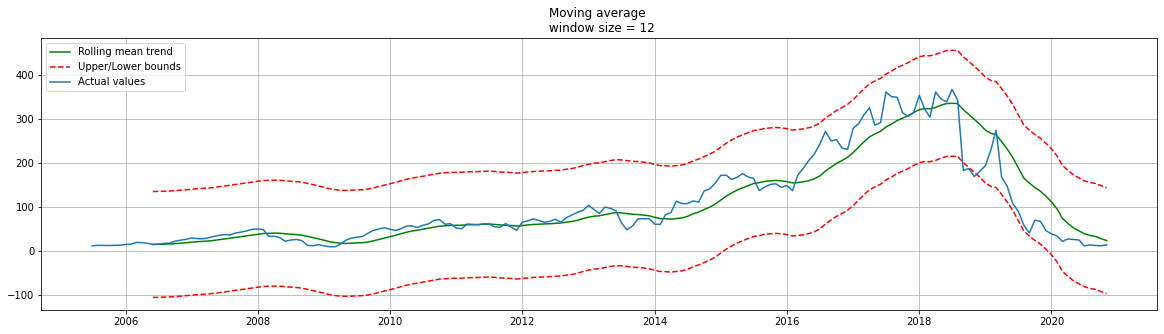

In [42]:
# plotting 12 months moving average 

ma(df['Close'],12, plot_intervals=True) # smoothing by previous 12 months

In [15]:
# function that returns weighted moving average
def wma(series, weights):
  """
  calculate weighted moving average of the series
  """
  result = 0.0
  for w in range(len(weights)):
    result += series.iloc[-w-1] * weights[w]
    return float(result)

wma(df['Close'], weights = [0.5, 0.3, 0.2])

7.335

### Now let's extend this concept of weighted averages to exponentially weighted moving averages

### **Exponentially weighted moving averages** weights all the available observations while exponentially decreasing the weights as we move back $k$ values 

## $$\hat{y}_{t+1} = \alpha \cdot y_t + \alpha(1-\alpha) \cdot y_{t-1} + \alpha(1-\alpha)^2 \cdot y_{t-2} + \alpha(1-\alpha)^3 \cdot y_{t-3} + .... $$

## $$ \hat{y}_{t+1} = \alpha \cdot y_t + (1-\alpha) \cdot \hat{y}_t $$

In [16]:
def exponential_smoothing(series, alpha):
  """
  series - dataframe column with timeseries
  alpha - smoothing parameter
  """
  result = [series[0]]
  for n in range(len(series)):
    result.append(alpha * series[n] + (1 - alpha) * result[n-1])
  return result

In [17]:
exponential_smoothing(df['Close'], 0.9)

[12.46,
 12.46,
 13.324,
 13.216000000000001,
 13.0234,
 13.390600000000001,
 13.64134,
 15.13606,
 15.872134,
 19.585606,
 19.1282134,
 18.1855606,
 15.970821339999999,
 16.36255606,
 17.653082134,
 18.250255606,
 22.267308213400003,
 24.6130255606,
 26.49973082134,
 29.605302556060003,
 28.416973082134,
 28.286530255606,
 30.120697308213398,
 32.9876530255606,
 35.394069730821336,
 37.43576530255606,
 36.830406973082134,
 40.967576530255606,
 42.81504069730821,
 45.65875765302556,
 49.11050406973082,
 50.051875765302555,
 49.389050406973084,
 35.380187576530254,
 35.59290504069731,
 31.555018757653023,
 24.12429050406973,
 26.060501875765304,
 26.55942905040697,
 24.323050187576527,
 14.877942905040696,
 13.466305018757653,
 15.014794290504069,
 12.362630501875765,
 10.735479429050407,
 10.218263050187577,
 14.97854794290504,
 23.629826305018756,
 28.209854794290504,
 31.099982630501877,
 32.92598547942905,
 40.00099826305019,
 45.8715985479429,
 49.513099826305016,
 52.6561598547942

In [18]:
def ema(series, alphas):
  """
  series - dataframe colummn with time series
  alpha - smoothing parameters
  """
  with plt.style.context('seaborn-white'):
    plt.figure(figsize=(20,5))
    for alpha in alphas:
      plt.plot(exponential_smoothing(series, alpha), label = "Alpha{}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.legend(loc="best")
    plt.grid(True)


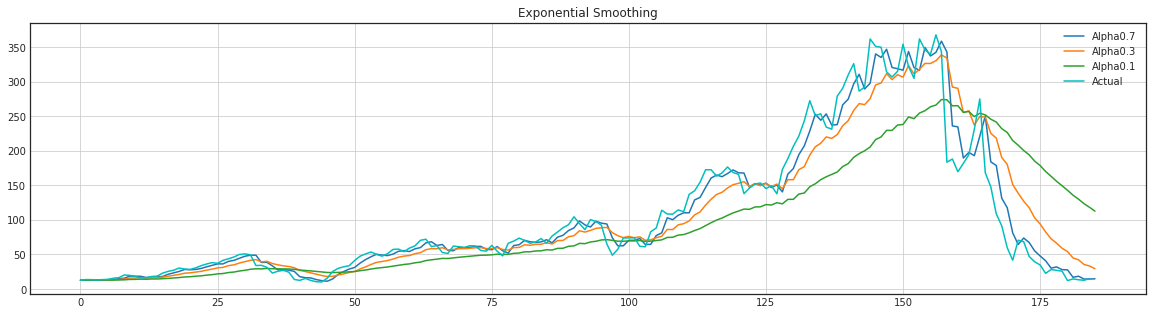

In [19]:
ema(df['Close'], [0.7, 0.3, 0.1])

## <b> Double exponential smoothing (Holt's linear trend method)

### So far we were able to make just one prediction, clearly which is isn't enough. Double exponential smooothing (Holt's linear trend method) is one such way to overcome this limitation. It has two components, intercept $l$ and slope $b$
## $$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$
## $$\ b_x = \beta (\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1} $$
## $$\hat{y}_{x+1} = \ell_x + \ b_x  $$

### The final prediction is the sum of the model values of the intercept and trend.


In [30]:
def double_exponential_smoothing(series, alpha, beta):
  """
  series - dataframe column with timeseries
  alpha - smoothing parameter for level
  beta - smoothing parameter for trend
  """
  # first value is same as series
  result = [series[0]]
  for n in range(1, len(series)+1):
      if n == 1:
          level, trend = series[0], series[1] - series[0]
      if n >= len(series): 
          value = result[-1]
      else:
          value = series[n]
      last_level, level = level, alpha*value + (1-alpha)*(level+trend)
      trend = beta*(level-last_level) + (1-beta)*trend
      result.append(level+trend)
  return result

In [25]:
def dema(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataframe column with timeseries
        alphas - smoothing parameters for level
        betas - smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 5))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

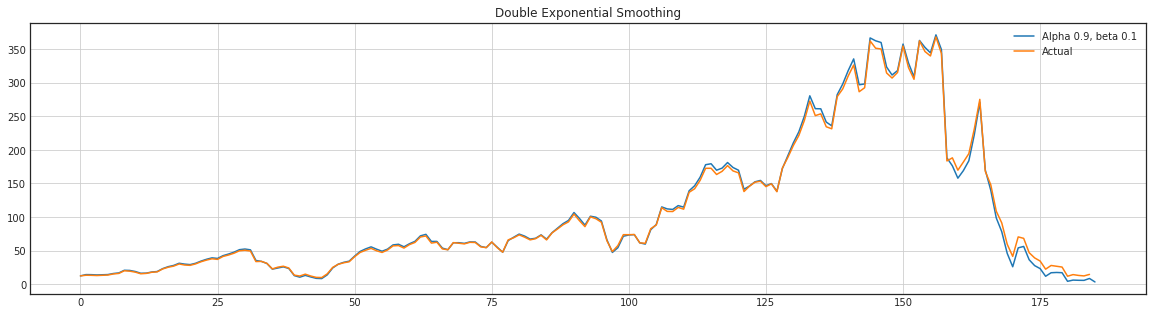

In [39]:
dema(df['Close'], alphas = [0.9], betas = [0.1])

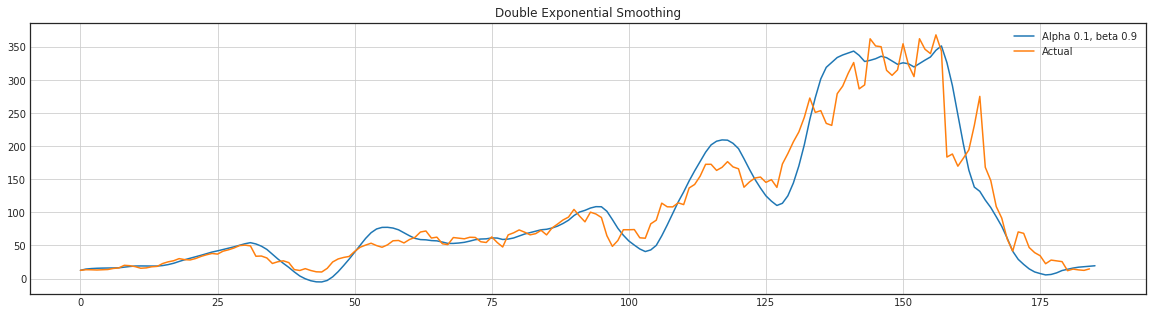

In [37]:
dema(df['Close'], alphas = [0.1], betas = [0.9])